In [6]:
#%%writefile Cointegration.py
#https://medium.com/@bart.chr/pairs-trading-for-algorithmic-trading-breakdown-d8b709f59372
#https://github.com/aconstandinou/mean-reversion

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import coint
import numpy as np
import pandas as pd
import statistics

import matplotlib.pyplot as plt

# Functions/Methods

In [120]:
"""
Augmented Dickey–Fuller (ADF) unit root test; p-value < .05
"""
class DickeyFuller(object):
    def __init__(self, significance=.05):
        self.significance_level = significance
        self.p_value = None
        self.perc_stat = None
        self.is_stationary = None
        
    def check(self, time_series):
        model = ts.adfuller(time_series, 1)
        self.p_value = model[1]
        self.perc_stat = model[0]
        
        self.is_stationary = False
        if (self.p_value < self.significance_level):
            self.is_stationary = True
        return self.is_stationary;

"""
Half Life test from the Ornstein-Uhlenbeck process 
"""
class HalfLife(object):
    def __init__(self):
        self.half_life = None

    def check(self, time_series):
        lag = np.roll(time_series, 1)
        lag[0] = 0
        ret = time_series - lag
        ret[0] = 0

        # adds intercept terms to X variable for regression
        lag2 = sm.add_constant(lag)
        res = sm.OLS(ret, lag2).fit()
        self.half_life = int(round(-np.log(2) / res.params[1],0))

        if self.half_life <= 0:
            self.half_life = 1
        return self.half_life

"""
If Hurst Exponent is under the 0.5 value of a random walk, then the series is mean reverting
"""
class HurstExponent():
    def __init__(self):
        self.h_min = 0.0
        self.h_max = 0.4
        self.look_back = 126
        #https://robotwealth.com/demystifying-the-hurst-exponent-part-1/
        self.lag_max = 20#era 100
        self.h_value = None
    
    def check(self, time_series):
        lags = range(2, self.lag_max)

        tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)

        self.h_value = poly[0]*2.0 
        return self.h_value

def model_ols(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model

# beta/coeficiente angular
def beta(y, x):
    model = model_ols(y, x)
    return model.params[1]

# check cointegrated pairs from dataframe
def find_cointegrated_pairs(data, num_pairs=0):
    adf = DickeyFuller()
    rows = []
    isBreak = False
    index=-1
    
    for y_symbol in data.columns:
        index = index + 1
        for x_symbol in data.columns[index+1:data.shape[1]]:#for x_symbol in data.columns:
            if (y_symbol == x_symbol):
                continue
            
            model = model_ols(data[y_symbol], data[x_symbol])
            adf.check(model.resid)
            beta = model.params[1]
            #if (adf.is_stationary):
            rows.append([y_symbol,x_symbol,adf.p_value, adf.perc_stat, beta])
                    
            # break for two
            isBreak = (num_pairs > 0 and len(rows) >= num_pairs)
            if (isBreak == True): break
        
        # break for one
        if (isBreak == True): break

    df_pairs = pd.DataFrame(rows, columns=['Dependente', 'Independente', 'pValue', 'ADFStatistic', 'Beta'])
    return df_pairs        
        
def cointegration(y, x, period = 0):
    adf = DickeyFuller()
    n = len(y)
    if (period > 0):
        pos = n-period
        y = y.iloc[pos:]
        x = x.iloc[pos:]
    else:
        period = n
        
    model = model_ols(y, x)
    adf.check(model.resid)
    return [adf.is_stationary, adf.p_value, adf.perc_stat, model.params[1], period]

def apply_halflife(data, pairs):
    pairs['HalfLife'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        
        value = check_halflife(y, x)
        pairs['HalfLife'].iloc[i]=value

def check_halflife(y, x):
    halflile = HalfLife()
    model = model_ols(y, x)
    return halflile.check(model.resid)

def apply_hurst(data, pairs):
    pairs['Hurst'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        
        value = check_hurst(y, x)
        pairs['Hurst'].iloc[i]= value

def check_hurst(y, x):
    hurst = HurstExponent()
    model = model_ols(y, x)
    return hurst.check(model.resid.as_matrix())

# 0.9 para mais ou para menos indica uma correlação muito forte.
# 0.7 a 0.9 positivo ou negativo indica uma correlação forte.percorre
# 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
# 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
# 0 a 0.3 positivo ou negativo indica uma correlação desprezível.'''
def corr_pearson(y, x):
    y_avg, x_avg = np.average(y), np.average(x)
    y_stdev, x_stdev = np.std(y), np.std(x)
    n = len(y)
    denominator = y_stdev * x_stdev * n
    numerator = np.sum(np.multiply(y-y_avg, x-x_avg))
    p_coef = numerator/denominator
    return p_coef

def apply_corr(data, pairs):
    pairs['Corr'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        
        corr = corr_pearson(y, x)
        pairs['Corr'].iloc[i] = corr

def signal(y, x):
    model = model_ols(y, x)
    std = statistics.stdev(model.resid)
    resi_curr = model.resid.iloc[-1]
    zscore_up = 2*std
    zscore_down = -2*std
    zcurrent = 0
    desc = ''
    
    # >0; resíduo acima da linha 0
    if(resi_curr > 0):
        desc = 'SL'
        zcurrent = zscore_up
    else:
        desc = 'LS'
        zcurrent = zscore_down
    
    percent = (abs(resi_curr)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return [desc, resi_curr, percent]

def apply_signal(data, pairs):
    pairs['Signal'] = ''
    pairs['SignalPerc'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]

        sig = signal(y, x)
        pairs['Signal'].iloc[i] = sig[0]
        pairs['SignalPerc'].iloc[i] = sig[2]

"""def apply_periods_cointegration(data, pairs, period):
    listper=[]
    if (type(period) is int):
        listper.append(period)
    else:
        listper = period
    
    pairs['Periods']
    for i, row in pairs.iterrows():
        y_symbol = row['Dependente']
        x_symbol = row['Independente']
        for per in listper:
            res = check_oneperiod(data, y_symbol, x_symbol, per)
            if (res[1]==True):
                rows.append([res[0], res[1]])"""
    
def check_periods(data, y_symbol, x_symbol, period):
    if (type(period) is int):
        return check_oneperiod(data, y_symbol, x_symbol, period)
    if (type(period) is list):
        rows=[]
        for p in period:
            res = check_oneperiod(data, y_symbol, x_symbol, p)
            rows.append([res[0], res[1]])
        return rows

def check_oneperiod(data, y_symbol, x_symbol, period):
    y = data[y_symbol]
    x = data[x_symbol]
    
    if(period > 0):
        pos = data.shape[0]-period
        y = y.iloc[pos:]
        x = x.iloc[pos:]
    
    adf = DickeyFuller()
    model = model_ols(y, x)
    adf.check(model.resid)
    beta = model.params[1]

    return [adf.p_value, adf.is_stationary];

def show(data, y_symbol, x_symbol):
    y = data[y_symbol]
    x = data[x_symbol]
    
    model= model_ols(y, x)
    std = statistics.stdev(model.resid)
    entry_threshold = 2 # entrada em 2 desvio padrão

    #plt.figure(figsize=(15,6))
    plt.figure(figsize=(10,5))
    plt.plot(model.resid)
    plt.ylabel('Residual')
    plt.title(y_symbol + ' / ' + x_symbol)

    plt.axhline(0, color='black',label='mean',linestyle='--') # Add the mean of residual
    plt.axhline(entry_threshold*std, color='green', linestyle='--',label='trade')
    plt.axhline(-entry_threshold*std, color='green', linestyle='--')

    plt.legend()
    plt.show()

## Read CSV

In [75]:
# todas as ações
#df = pd.read_csv('datasets/data.csv')

# somentes as ações que fazem parte da carteira ibovespa
df = pd.read_csv('datasets/data_cart.csv',index_col=0)#[['ABEV3', 'AZUL4', 'B3SA3', 'BBAS3', 'BBDC3']]

data = df[df.columns.difference(['Data'])]
data.shape

(355, 71)

In [76]:
pairs = find_cointegrated_pairs(data, 0)
pairs.head(3)

,Dependente,Independente,pValue,ADFStatistic,Beta
0,ABEV3,AZUL4,0.248276,-2.090687,0.152839
1,ABEV3,B3SA3,0.847264,-0.698009,0.058191
2,ABEV3,BBAS3,0.027352,-3.089339,0.264904


In [77]:
apply_halflife(data, pairs)
print('Half-Life applied successfully')

Half-Life applied successfully


In [78]:
apply_hurst(data, pairs)
print('Hurst applied successfully')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:144: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Hurst applied successfully


In [79]:
apply_corr(data, pairs)
print('Correlation applied successfully')

Correlation applied successfully


In [80]:
apply_signal(data, pairs)
print('Signal applied successfully')

Signal applied successfully


In [81]:
pairs.head(3)

,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr,Signal,SignalPerc
0,ABEV3,AZUL4,0.248276,-2.090687,0.152839,23,0.439056,0.853351,SL,0.051128
1,ABEV3,B3SA3,0.847264,-0.698009,0.058191,107,0.491236,0.154203,LS,0.705434
2,ABEV3,BBAS3,0.027352,-3.089339,0.264904,14,0.397299,0.875547,LS,0.053038


In [82]:
pairs.to_csv('datasets/cointegrated_pairs.csv', index=False)
print('Criado com sucesso!!!')

Criado com sucesso!!!


# Analysis

In [83]:
pairs = pd.read_csv('datasets/cointegrated_pairs.csv')
pairs.shape

(2485, 10)

In [84]:
df_hurst = pairs.loc[(pairs['Hurst'] > 0) & (pairs['Hurst'] < 0.4)]
df_hurst

,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr,Signal,SignalPerc
2,ABEV3,BBAS3,0.027352,-3.089339,0.264904,14,0.397299,0.875547,LS,0.053038
5,ABEV3,BBSE3,0.304453,-1.959844,0.453826,30,0.321713,0.739251,LS,0.560796
10,ABEV3,BRFS3,0.231443,-2.133027,0.268774,27,0.374320,0.770924,LS,0.393191
12,ABEV3,BRML3,0.476219,-1.613346,0.656802,38,0.352629,0.703001,LS,0.285786
14,ABEV3,CCRO3,0.644550,-1.266068,0.555108,63,0.326291,0.533061,LS,0.668427
...,...,...,...,...,...,...,...,...,...,...
2463,TIMP3,WEGE3,0.134937,-2.424513,0.155557,15,0.317630,0.805781,LS,0.466036
2467,TOTS3,VIVT4,0.000125,-4.606812,3.066138,7,0.293995,0.841575,LS,1.042910
2475,USIM5,VALE3,0.416301,-1.728874,0.260024,27,0.357497,0.608797,LS,1.033873
2482,VIVT4,VVAR3,0.446068,-1.671085,0.942055,26,0.317226,0.728812,LS,1.834924


In [87]:
corr = df_hurst.loc[(df_hurst['Corr'] >= 0.95)]
corr

,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr,Signal,SignalPerc
231,BBAS3,EMBR3,0.004834,-3.652426,1.923078,8,0.380021,0.953200,SL,0.997803
246,BBAS3,ITUB4,0.022591,-3.157332,1.601157,13,0.337331,0.951472,LS,0.254709
858,BRML3,IGTA3,0.012266,-3.363538,0.363442,8,0.280962,0.975255,LS,0.651148
865,BRML3,LREN3,0.012102,-3.367929,0.389465,7,0.226296,0.956094,LS,1.753095
869,BRML3,MULT3,0.000125,-4.607207,0.620645,6,0.133425,0.978293,LS,0.804308
1495,ELET3,ELET6,0.003196,-3.772997,1.089638,8,0.339536,0.988390,SL,0.249313
1611,EMBR3,SANB11,0.012253,-3.363907,0.514330,11,0.373317,0.953965,LS,1.051304
1783,GGBR4,GOAU4,0.003928,-3.713475,2.033404,6,0.236222,0.993192,SL,0.247711
1821,GNDI3,HAPV3,0.004715,-3.659843,1.143979,10,0.363336,0.975516,LS,0.143939
1844,GNDI3,SULA11,0.144468,-2.390386,1.160121,17,0.339205,0.950655,SL,1.382178


In [88]:
signal = corr.loc[(df_hurst['SignalPerc'] >= 0.95)]
signal

,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr,Signal,SignalPerc
231,BBAS3,EMBR3,0.004834,-3.652426,1.923078,8,0.380021,0.953200,SL,0.997803
865,BRML3,LREN3,0.012102,-3.367929,0.389465,7,0.226296,0.956094,LS,1.753095
1611,EMBR3,SANB11,0.012253,-3.363907,0.514330,11,0.373317,0.953965,LS,1.051304
1844,GNDI3,SULA11,0.144468,-2.390386,1.160121,17,0.339205,0.950655,SL,1.382178
2026,IGTA3,LREN3,0.000744,-4.168615,1.050753,7,0.297478,0.961280,LS,1.379036
2212,LREN3,MULT3,0.000068,-4.750407,1.512641,5,0.250833,0.971247,SL,1.438070


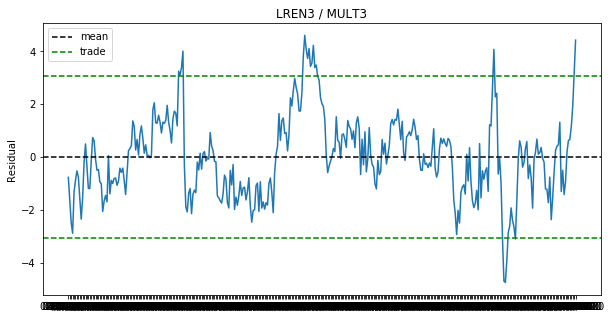

In [89]:
show(data, 'LREN3', 'MULT3')

In [97]:
check_periods(data, 'LREN3', 'MULT3', [100, 120, 140, 160, 180, 200, 220, 240, 250])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


[6.759838690518091e-05, True]

In [132]:
cointegration(data['BBAS3'], data['EMBR3'], 100)

[False, 0.2778889471221694, -2.0199635677947305, 1.914343853136128, 100]

In [144]:
def analysis_pairs(y, x):
    rows=[]
    n = len(y)
    adf = DickeyFuller()
    
    for period in [100, 120, 140, 160, 180, 200, 220, 240, 250]:
        pos = n-period
        y_ = y.iloc[pos:]
        x_ = x.iloc[pos:]
        
        coin = cointegration(y_, x_, 0)
        half_life = check_halflife(y_, x_)
        hurst = check_hurst(y_, x_)
        corr = corr_pearson(y_, x_)
            
        rows.append([period, coin[0], coin[1], coin[1], coin[2], half_life, hurst, corr])
        
    analysis = pd.DataFrame(rows, columns=['Period', 'Stationary', 'pValue', 'ADFStatistic', 'Beta', 'HalfLife', 'Hurst', 'Corr'])
    return analysis

In [146]:
analysis_pairs(data['BBAS3'], data['EMBR3'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


,Period,Stationary,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr
0,100,False,0.277889,0.277889,-2.019964,7,0.317155,0.966646
1,120,False,0.201204,0.201204,-2.213998,7,0.294523,0.974144
2,140,False,0.117250,0.117250,-2.492743,7,0.285624,0.975960
3,160,False,0.069614,0.069614,-2.726193,7,0.279564,0.976320
4,180,False,0.121475,0.121475,-2.475795,7,0.299730,0.973365
5,200,True,0.024311,0.024311,-3.131461,6,0.270507,0.972483
6,220,True,0.012201,0.012201,-3.365286,6,0.287674,0.972612
7,240,True,0.017075,0.017075,-3.253785,8,0.322341,0.967577
8,250,True,0.022340,0.022340,-3.161248,8,0.311387,0.965900
